Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import Dinov2Model, AutoImageProcessor

In [4]:
from util import *

In [5]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [6]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                # v2.RandomErasing(p=0.5, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize((0.1880, 0.1893, 0.1923), (0.3024, 0.3022, 0.3057)),
                        v2.RandomApply(random_trans, 0.2)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True)])

In [7]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [8]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [9]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=45, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=True)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Model setup

In [10]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),   # → (16, 320, 320)
    nn.ReLU(),
    nn.MaxPool2d(2),                              # → (16, 160, 160)

    nn.Conv2d(16, 32, kernel_size=3, padding=1),  # → (32, 160, 160)
    nn.ReLU(),
    nn.MaxPool2d(2),                              # → (32, 80, 80)

    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → (64, 80, 80)
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),                      # → (64, 1, 1)

    nn.Flatten(),                                 # → (64,)
    nn.Linear(64, 1)
)

Train

In [11]:
from torchinfo import summary
summary(model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Conv2d: 1-1                            [1, 16, 320, 320]         448
├─ReLU: 1-2                              [1, 16, 320, 320]         --
├─MaxPool2d: 1-3                         [1, 16, 160, 160]         --
├─Conv2d: 1-4                            [1, 32, 160, 160]         4,640
├─ReLU: 1-5                              [1, 32, 160, 160]         --
├─MaxPool2d: 1-6                         [1, 32, 80, 80]           --
├─Conv2d: 1-7                            [1, 64, 80, 80]           18,496
├─ReLU: 1-8                              [1, 64, 80, 80]           --
├─AdaptiveAvgPool2d: 1-9                 [1, 64, 1, 1]             --
├─Flatten: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 1]                    65
Total params: 23,649
Trainable params: 23,649
Non-trainable params: 0
Total m

In [12]:
# hard code best paramm
lr = 1e-03
wd= 1e-5
beta = (0.9, 0.998)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=wd, betas= beta)
data = train(model, optimizer, loader_train, loader_val, device, epochs=70)

Iter: 1/140   |  Loss: 0.692766  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Sample preds : [48.3%, 48.0%, 48.5%, 48.4%, 48.2%, 48.2%, 48.5%, 48.1%, 48.4%, 48.5%, 48.5%, 48.3%, 48.4%, 48.2%, 48.2%, 48.3%, 48.4%, 48.2%, 48.5%]
Sample labels: [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Iter: 2/140   |  Loss: 0.690976  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Iter: 3/140   |  Loss: 0.684361  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Sample preds : [47.3%, 47.5%, 47.9%, 47.3%, 47.3%, 47.8%, 47.3%, 47.6%, 47.7%, 47.4%, 47.1%, 47.6%, 47.7%, 47.6%, 47.2%, 47.8%, 47.7%, 47.9%, 47.6%]
Sample labels: [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Iter: 4/140   |  Loss: 0.701173  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Iter: 5/140   |  Loss: 0.690565  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Sample preds : [47.8%, 47.3%, 47.1%, 47.8%, 47.6%, 47.5%, 47.6%, 47.5%, 47.1%, 47.4%, 47.2%, 47.7%, 47.7%

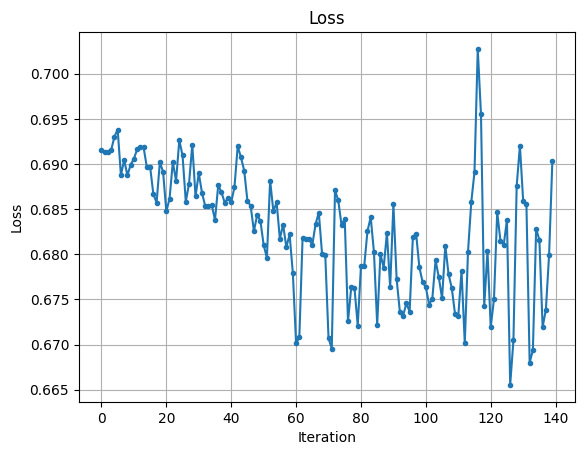

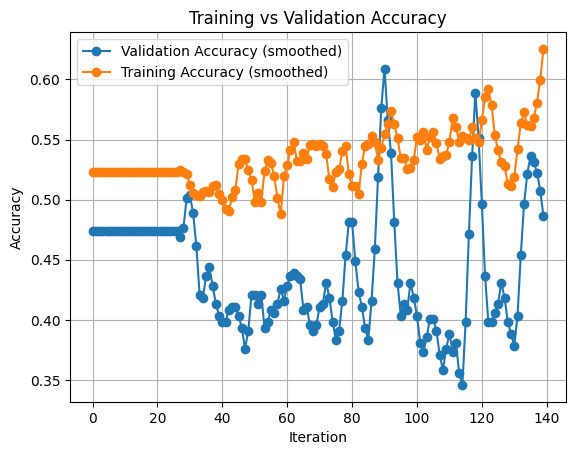

In [14]:
plotpic(data)

In [15]:
check_accuracy_final(loader_test, model, device, out=True)

Sample preds : [50.5%, 46.6%, 54.2%, 57.0%, 55.5%, 54.8%, 52.4%, 53.1%, 48.1%, 54.8%, 50.8%, 52.3%, 58.0%, 42.4%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.42857142857142855

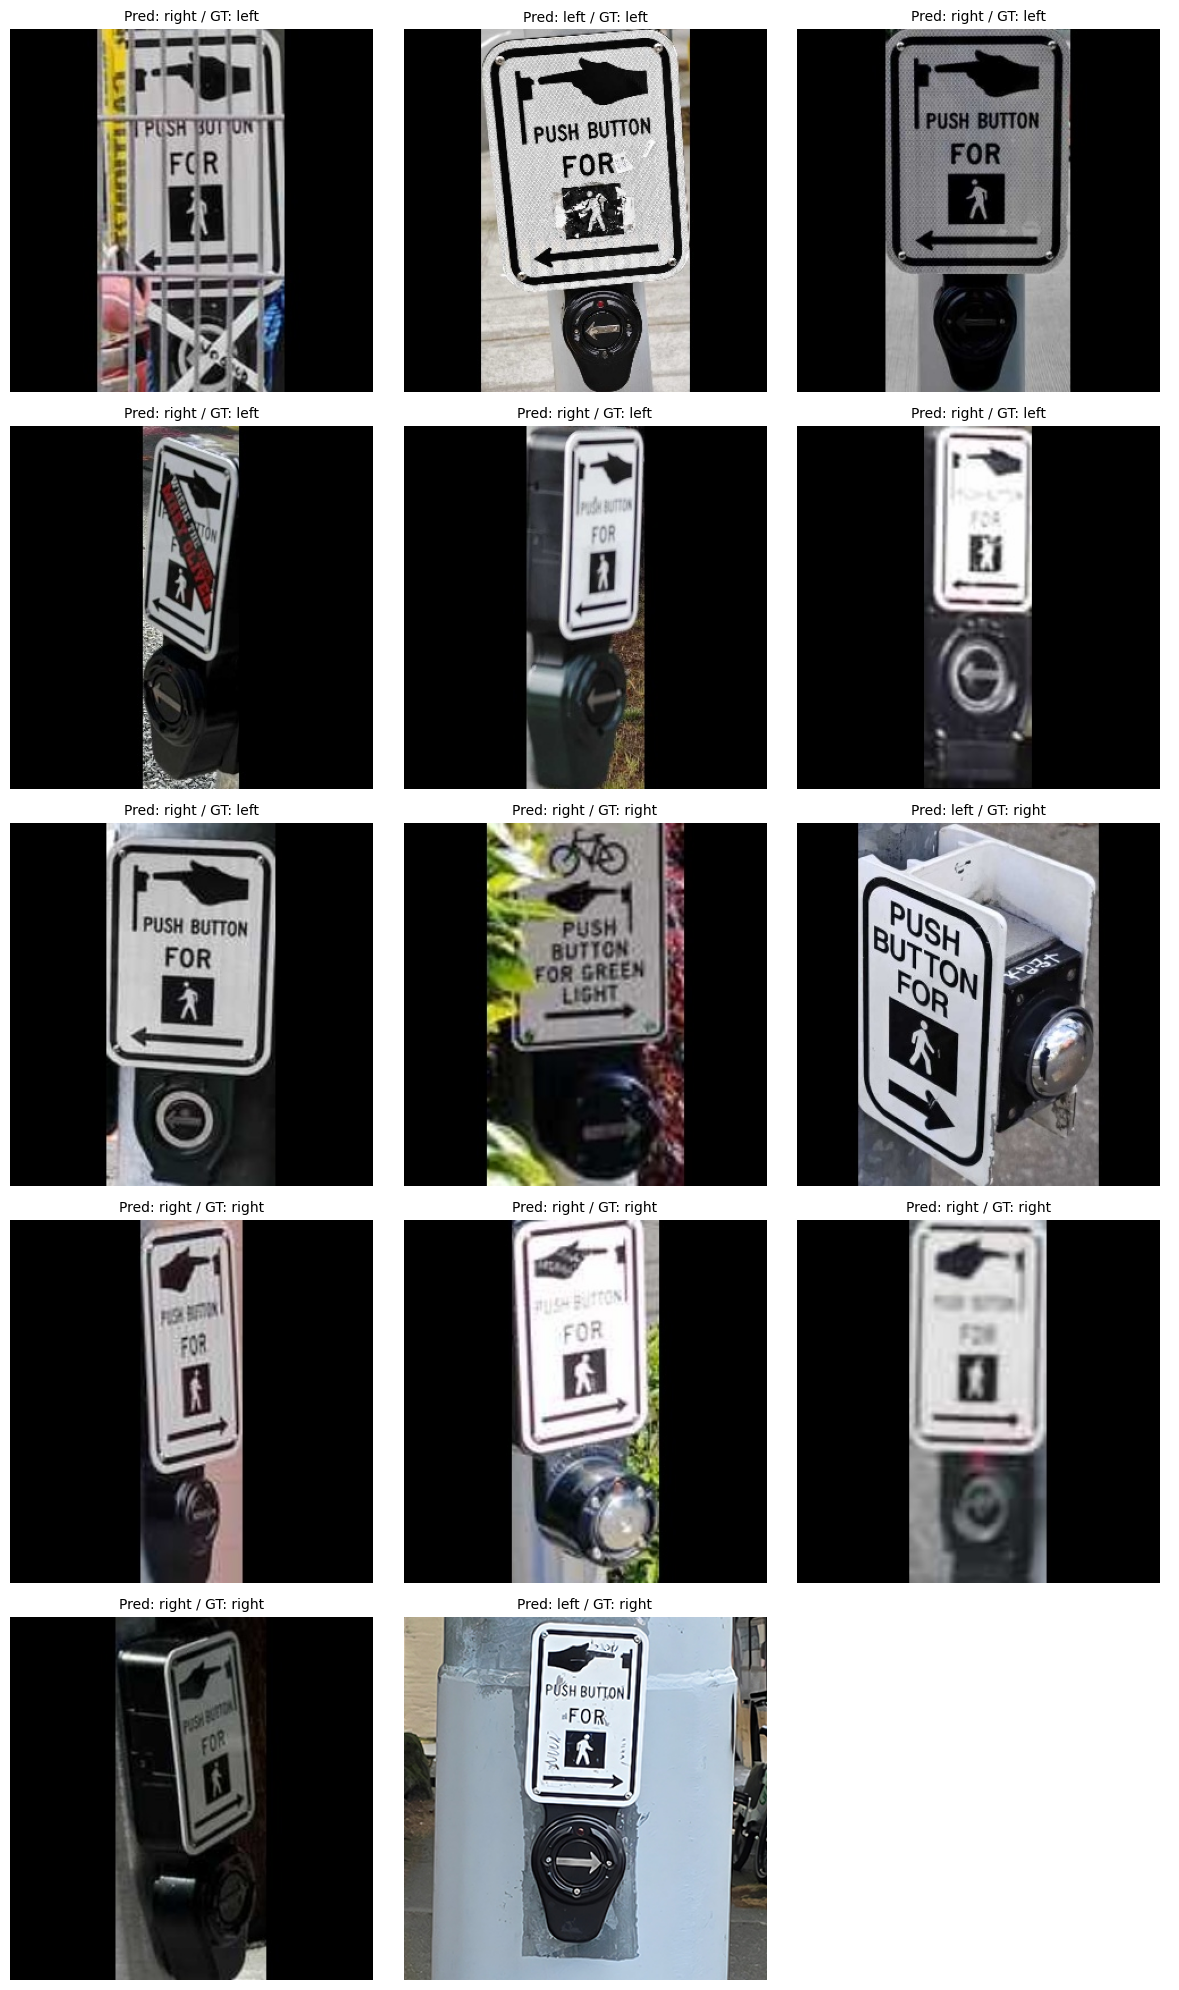

In [16]:
show_predictions_grid(loader_test, model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [17]:
torch.save(model.state_dict(), "conv_weights.pth")